# 8. From bagging to Random forest

A downside of bagging is that dominant features can cause individual trees to have a similar structure **known as tree correlation**.
Remember the feature importance results discussed earlier for the MTPL data?
* ```bm``` is a very dominant variable
* ```ageph``` was rather important
* ```power``` also, but to a lesser degree.

Problem?
* bagging gets its predictive performance from **variance reduction**
* however, this reduction when tree correlation
* dominant features therefore **hurt** the preditive performance of a bagged ensemble!

In [42]:
import matplotlib.pyplot as plt
from sklearn import tree
import pandas as pd
import numpy as np
import os

In [43]:
df = pd.read_csv(r'.\data\PC_data.txt', sep = '\s+')
df.columns = map(str.lower, df.columns)
df = df.drop('id', axis = 1)
df.head()

,nclaims,amount,avg,exp,coverage,fuel,use,fleet,sex,ageph,bm,agec,power,pc,town,long,lat
0,1,1618.001036,1618.001036,1.000000,TPL,gasoline,private,N,male,50,5,12,77,1000,BRUSSEL,4.355223,50.845386
1,0,0.000000,NaN,1.000000,PO,gasoline,private,N,female,64,5,3,66,1000,BRUSSEL,4.355223,50.845386
2,0,0.000000,NaN,1.000000,TPL,diesel,private,N,male,60,0,10,70,1000,BRUSSEL,4.355223,50.845386
3,0,0.000000,NaN,1.000000,TPL,gasoline,private,N,male,77,0,15,57,1000,BRUSSEL,4.355223,50.845386
4,1,155.974606,155.974606,0.046575,TPL,gasoline,private,N,female,28,9,7,70,1000,BRUSSEL,4.355223,50.845386


In [44]:
# converting type(str) columns to categorical
df['coverage'] = df['coverage'].astype('category').cat.codes
df['fleet'] = df['fleet'].astype('category').cat.codes
df['sex'] = df['sex'].astype('category').cat.codes
df['town'] = df['town'].astype('category').cat.codes
df['fuel'] = df['fuel'].astype('category').cat.codes
df['use'] = df['use'].astype('category').cat.codes

In [45]:
col_names = ['ageph','agec','bm','power','coverage','fuel','sex','fleet','use']

In [46]:
sample_1 = df.sample(df.shape[0], replace = True)
sample_2 = df.sample(df.shape[0], replace = True)

In [47]:
exp_1 = sample_1.exp
y_1 = np.array(sample_1['nclaims']/sample_1['exp']).ravel()
x_1 = np.array(sample_1[['ageph','agec','bm','power','coverage','fuel','sex','fleet','use']])

In [49]:
exp_2 = sample_2.exp
y_2 = np.array(sample_2['nclaims']/sample_2['exp']).ravel()
x_2 = np.array(sample_2[['ageph','agec','bm','power','coverage','fuel','sex','fleet','use']])

In [53]:
rgf_dt_1 = tree.DecisionTreeRegressor(criterion="mse", max_depth = 3,
                                      min_samples_split = 2000,
                                      min_samples_leaf = 1000,
                                      ccp_alpha = 0, splitter="best").fit(x_1,y_1,exp_1)

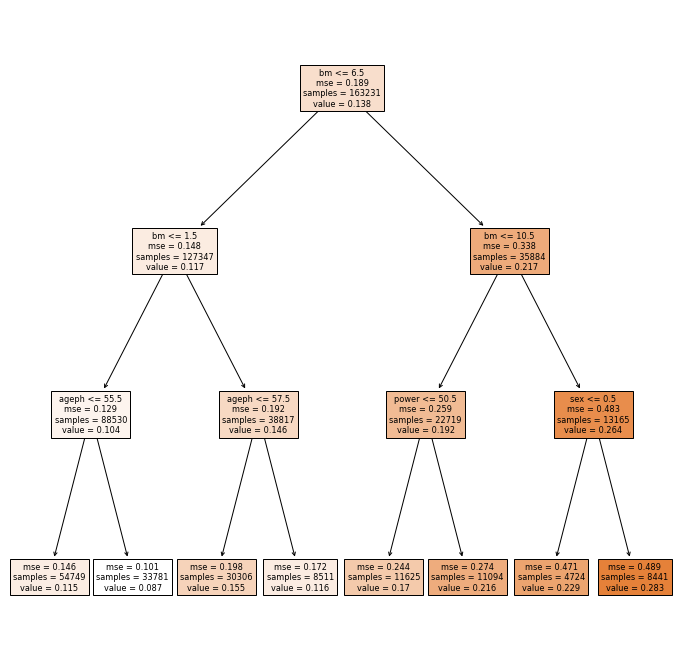

In [54]:
%matplotlib inline
plt.figure(figsize=(12,12))
_ = tree.plot_tree(rgf_d_1, 
                   feature_names = col_names,
                   filled = True)

In [57]:
rgf_dt_2 = tree.DecisionTreeRegressor(criterion="mse", max_depth = 3,
                                      min_samples_split = 2000,
                                      min_samples_leaf = 1000,
                                      ccp_alpha = 0, splitter="best").fit(x_2,y_2,exp_2)

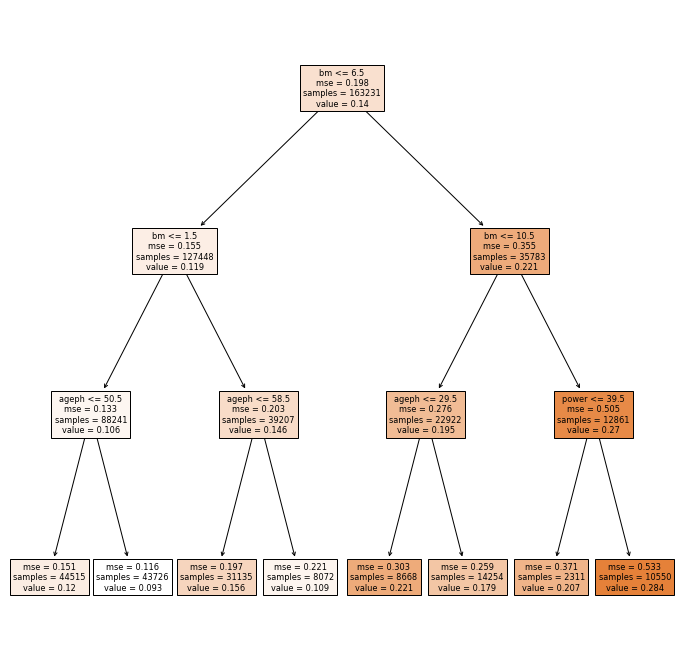

In [58]:
%matplotlib inline
plt.figure(figsize=(12,12))
_ = tree.plot_tree(rgf_dt_2, 
                   feature_names = col_names,
                   filled = True)

### 8.1 Random Forest

**Random forest** is a modification on bagging to get an ensemble of de-correlated trees.Process is very similar to bagging, with one small trick:
* before each split, select a subset of features at random as candidate features for splitting
* this essentially decorrelates the trees in the ensemble, improving predictive performance
* the number of candidates is typically considered a tuning parameter.

Note:
* **Bagging** introduces randomness in the rows of the data
* **Random** forest introduces randomness in the rows and columns of the data.

The ```RandomForestRegressor``` is trained using bootstrap aggregation, where each new tree is fit from a bootstrap sample of the training observations. 

The **out-of-bag (OOB) error** is the average error for each  calculated using predictions from the trees that do not contain in their respective bootstrap sample. This allows the ```RandomForestRegressor``` to be fit and validated whilst being trained 1.

The example below demonstrates how the OOB error can be measured at the addition of each new tree during training. The resulting plot allows a practitioner to approximate a suitable value of n_estimators at which the error stabilizes.

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
exp = df['exp']
y = np.array(df['nclaims']/df['exp'])
x = np.array(df[['ageph','agec','bm','power','coverage','fuel','sex','fleet','use']])

In [112]:
rnd_forest = RandomForestRegressor(n_estimators=100, criterion='poisson', oob_score=True).fit(x,y,sample_weight = exp)

In [113]:
rnd_forest.predict(x)

array([0.36188414, 0.04825756, 0.05799063, ..., 0.07913702, 0.08660048,
       0.61960145])

In [114]:
rnd_forest.oob_score_

-0.033311810233468186

In [80]:
# range of 'n_estimators' values to explore
min_estimators = 1
max_estimators = 100
error_rate = []

for i in range(min_estimators, max_estimators + 1):
    rnd_forest.set_params(n_estimators=i)
    rnd_forest.fit(x,y,sample_weight = exp)

    # record the OOB error for each 'n_estimators=i' setting
    oob_error = 1 - rnd_forest.oob_score_
    error_rate.append((i, oob_error))

C:\Users\Lorenzo\anaconda3\envs\dev_env\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Lorenzo\anaconda3\envs\dev_env\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Lorenzo\anaconda3\envs\dev_env\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Lorenzo\anaconda3\envs\dev_env\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to comput

KeyboardInterrupt: 

In [89]:
from sklearn.model_selection import GridSearchCV

In [93]:
parameters = {'n_estimators': [3,4,5],
              'max_depth': [2, 6, 8],
              'min_samples_leaf': [0.001, 0.01]*df.shape[0],
              'min_samples_split': [0.001, 0.01],
              }

In [95]:
grid_rnd_forest = GridSearchCV(rnd_forest, parameters, cv=5)
grid_rnd_forest.fit(x,y,sample_weight=exp)

C:\Users\Lorenzo\anaconda3\envs\dev_env\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Lorenzo\anaconda3\envs\dev_env\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Lorenzo\anaconda3\envs\dev_env\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Lorenzo\anaconda3\envs\dev_env\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to comput

KeyboardInterrupt: 

In [96]:
print("R-Squared::{}".format(grid_rnd_forest.best_score_))
print("Best Hyperparameters::\n{}".format(grid_rnd_forest.best_params_))

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'